---
---


<center><h1> Spark ML - Click Prediction </h1></center>

----

An Advertising company delivers more than 3 Billion clicks per month to its advertisers delivering 4.5 Million monthly sales events. 

It buys space on the Publishers site and then shows an advertisement about the Advertiser at that space. The advertiser pays the network for every conversion from the clicks. The network in turns pays to the publisher after keeping it's commission. The company wants to leverage the machine learning to improve the conversions for its customers.

So, in this notebook we will build a classification model to predict whether a particular advertisement will be clicked or not.

----

So for this notebook, we have divided the dataset into 3 different parts:
   * **`TRAIN`** - It has 1400000 Rows which will be used to train the model.
   * **`VALIDATION`** - It has 350000 Rows which will be used to evaluate the model.
   * **`TEST`** - It has 350000 Rows on which we will test our final model.



---

#### `IMPORTING THE REQUIRED LIBRARIES`

---

In [ ]:
# # uncomment and run the following command to install the matplotlib 
# !pip3 install matplotlib --user

In [1]:
# importing the required libraries
from pyspark.sql import SparkSession
import pyspark.sql.types as tp
from pyspark.sql import functions as F

# libraries to make plots
import matplotlib.pyplot as plt
%matplotlib inline

#### `Create Spark Session`

---

In [2]:
# create spark session
spark = SparkSession.builder.getOrCreate()

---

#### `READING THE DATASET`

---

Now, first of all, we will read all the datasets and each of the datasets the following columns

 * **`ID`**:   Unique ID of the Click
 * **`Country`**:   Country Code
 * **`Carrier`**:   Wireless Network Operator Code
 * **`TrafficType`**:  Whether the advertisement is for Adults or mainstream.
 * **`ClickDate`**:  Date at which the advertisement was clicked
 * **`Device`**:  Type of Device from which advertisement was clicked
 * **`Browser`**:  Type of Browser from which advertisement was clicked
 * **`OS`**:  Type of OS from which advertisement was clicked
 * **`publisherID`**:  Unique ID of publisher
 * **`advertiserCampaignId`**: Unique ID of campaign of advertisement
 * **`Fraud`**:  If the click was fraud or not
 * **`ConversionStatus`**:  If the click was fraud or not  ( **`Target Variable`** )

---

---

The data looks something like this:

---


![](images/sample_data.png)

---

In [3]:
# reading the train data
train_data = spark.read.csv("Spark_ML_Project/dataset/train.csv",inferSchema=True, header=True)

# reading the validation data
valid_data = spark.read.csv("Spark_ML_Project/dataset/valid.csv",inferSchema=True, header=True)

# reading the test data
test_data  = spark.read.csv("Spark_ML_Project/dataset/test.csv", inferSchema=True, header=True)

---

# `DATA EXPLORATION`

Now, that we have read the data, the first step is to explore the data. We will try to find out the following things from the data.

---
**`1. Variable Identification`**

- Data Type of the columns

**`2. Univariate Analysis`**
- Explore the Target Variable ( `ConversionStatus` )
- Check for the Null Values in each column
- Check for the Distinct Values in each column
- Frequency of each category for the following columns
    - Country
    - Browser
    - Device
    - OS

**`3. Bivariate Analysis`**

- Number of Clicks for each category of Country
- Number of Clicks for each catefory of Browser
- Number of Clicks for each catefory of Device
- Number of Clicks for each catefory of OS

---

##  `VARIABLE INDENTIFICATION`

#### `Data Type of the Columns`

---

In [4]:
# data type of the columns
train_data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Carrier: double (nullable = true)
 |-- TrafficType: string (nullable = true)
 |-- ClickDate: timestamp (nullable = true)
 |-- Device: string (nullable = true)
 |-- Browser: string (nullable = true)
 |-- OS: string (nullable = true)
 |-- ConversionStatus: boolean (nullable = true)
 |-- publisherId: string (nullable = true)
 |-- advertiserCampaignId: double (nullable = true)
 |-- Fraud: double (nullable = true)



---

**`Numerical`**
- ID
- Carrier (It is numerical in nature but it is `network code`, so we will treat it as `categorical variable`)
- Fraud
- advertiserCampaignId (It is numerical in nature but still values are code representing different campaigns, so we will treat it as `categorical variable`)

**`Categorical`**
- Country
- TrafficType
- Device
- Browser
- OS
- publisherId


**`Time-Based`**
- ClickDate

**`Boolean`**
- ConversionStatus (We will have to type cast it into the integer type to do some aggregation operations on it for the data exploration purposes.)


---

## `UNIVARIATE ANALYSIS`

---

#### `Exploring the Target Variable`

---

The `Target Variable` for our use-case is `ConversionStatus` and this column has `boolean` data type. Let's find out how much the data is imbalance, i.e. what percentage of data points has the target variable `true` and `false`?

---

In [5]:
# number of data points in each category and their percentage
target_variable = train_data.groupBy("ConversionStatus").agg(F.count("ConversionStatus"),
                                                            (F.count("ConversionStatus")/train_data.count())*100)
target_variable.show()

+----------------+-----------------------+-------------------------------------------+
|ConversionStatus|count(ConversionStatus)|((count(ConversionStatus) / 1400000) * 100)|
+----------------+-----------------------+-------------------------------------------+
|            true|                    874|                       0.062428571428571424|
|           false|                1399126|                          99.93757142857143|
+----------------+-----------------------+-------------------------------------------+



Let's change these columns names to simpler ones using the `alias` function and also round of the percentage upto 4 decimal places.

---

In [6]:
# number of data points in each category and their percentage upto 4 decimal points
target_variable = train_data.groupBy("ConversionStatus").agg(F.count("ConversionStatus").alias("count"),
                                           F.round((F.count("ConversionStatus")/train_data.count())*100, 4).alias("percentage"))

target_variable.show()

+----------------+-------+----------+
|ConversionStatus|  count|percentage|
+----------------+-------+----------+
|            true|    874|    0.0624|
|           false|1399126|   99.9376|
+----------------+-------+----------+



---

The data type of the target variable is `Boolean` in nature and we won't be able to use it in this format for further exploration So, let's first, we will change data type of the target variable `ConversionStatus` from `Boolean` to `Integer`.

---

In [7]:
# type cast the target variable
train_data = train_data.withColumn("ConversionStatus", F.col("ConversionStatus").cast(tp.IntegerType()))

In [8]:
# type cast the target variable of test and validation data
valid_data = valid_data.withColumn("ConversionStatus", F.col("ConversionStatus").cast(tp.IntegerType()))
test_data = test_data.withColumn("ConversionStatus", F.col("ConversionStatus").cast(tp.IntegerType()))

----

#### `CHECK FOR THE NULL VALUES IN EACH COLUMN`

---

In [9]:
### null values in each column
for c in train_data.columns:
    # define the condition
    missing_values = F.isnull(c)
    
    # filter the data with condition and count the number of data points
    missing_values = train_data.filter(missing_values).count()
    
    # print the result
    print(c, missing_values)

ID 0
Country 7514
Carrier 0
TrafficType 200726
ClickDate 0
Device 1836
Browser 5065
OS 4776
ConversionStatus 0
publisherId 0
advertiserCampaignId 5
Fraud 0


---

So, we have null values in most of the columns:

 * **`ID`**:   0
 * **`Country`**:   7514
 * **`Carrier`**:   0
 * **`TrafficType`**:  200726
 * **`ClickDate`**:  0
 * **`Device`**:  1836
 * **`Browser`**:  5065
 * **`OS`**:  4776
 * **`publisherID`**:  0
 * **`advertiserCampaignId`**: 5
 * **`Fraud`**:  0
 * **`ConversionStatus`**:  0


---

---

#### `Distinct Values in Each Column`

---

Next, we will find out the number of distinct values in each of the column. 

---

In [10]:
# distinct values in each column
train_data.agg(*(F.countDistinct(F.col(c)).alias(c) for c in train_data.columns))

ID,Country,Carrier,TrafficType,ClickDate,Device,Browser,OS,ConversionStatus,publisherId,advertiserCampaignId,Fraud
1400000,196,291,2,28253,764,30,15,2,2052,500,2


---

 - There are 1400000 unique values in the `ID` column i.e unique for each row. So it won't add any value to our ML model, therefore we will not include it, when we will train our model.
 - There are 196 different countries. 764 different devices in the data.
 - There are so many unique values in `ClickDate` column, it is because the data is collected every few seconds.
 - There are 500 different campaigns and over 2000 different publishers.


---

---



#### `Column - Country`

Next, we will explore the Country column. We have already seen that the dataset has 196 unique countries. Let's check the number of datapoints with each country code using the groupBy function.

---

In [11]:
# number of datapoints with each country
top_countries = train_data.groupBy("Country").agg(F.count("Country").alias("country_count"))
top_countries.show(10)

+-------+-------------+
|Country|country_count|
+-------+-------------+
|     DZ|        13232|
|     MM|         4666|
|     LT|           41|
|     CI|          277|
|     TC|            1|
|     AZ|          230|
|     FI|           21|
|     SC|            1|
|     UA|          219|
|     RO|          200|
+-------+-------------+
only showing top 10 rows



---

View the Top 25 countries in the data using the orderBy.

---

In [12]:
# Top 25 countries in the dataset
top_countries.orderBy("country_count",ascending=False).show(25)

+-------+-------------+
|Country|country_count|
+-------+-------------+
|     IN|       391465|
|     TH|       230027|
|     ID|       119701|
|     BD|       106342|
|     MX|        58908|
|     BR|        57664|
|     RU|        41288|
|     NG|        36244|
|     MY|        29340|
|     US|        26339|
|     BO|        21602|
|     PH|        19815|
|     ZA|        15835|
|     VE|        15405|
|     GT|        13781|
|     DZ|        13232|
|     KR|        12906|
|     CO|        12877|
|     IQ|        12581|
|     AE|        10512|
|     ES|         8785|
|     IR|         8588|
|     UK|         7824|
|     IT|         7289|
|     PE|         6531|
+-------+-------------+
only showing top 25 rows



---

Now, we have 196 different countries in the dataset but most of the data points belong to the 20 countries. They have atleast 10,000 rows. So, in the dataset, we will keep only top 25 countries and map rest of them as `Others`.

---

To do the mapping, let's define a function.

---

In [13]:
# create list of top 20 countries, you can change the parameter in the limit function to choose any other number of countries
top_20_countries = (top_countries.orderBy("country_count",ascending=False).limit(20).select("Country").collect())
top_20_countries = [ row.Country for row in top_20_countries]
print(top_20_countries)

# define function to map countries
def map_countries(x):
    if x not in top_20_countries:
        return "Others"
    else:
        return x

['IN', 'TH', 'ID', 'BD', 'MX', 'BR', 'RU', 'NG', 'MY', 'US', 'BO', 'PH', 'ZA', 'VE', 'GT', 'DZ', 'KR', 'CO', 'IQ', 'AE']


----

Convert the function to the `UDF` function with return type as `String`.

----

In [14]:
# convert to udf function
map_countries_udf = F.udf(f= map_countries, returnType= tp.StringType())

---

Use the function `withColumn` & `map_countries_udf` to map the countries in the original data.

---

In [15]:
# map the countries
train_data = train_data.withColumn("country_modified", map_countries_udf(train_data["Country"]))

----

Now, we have reduced the number of distinct countries from `196` to `21`. Let's check the number of data points with each of the country we have now.

----

In [16]:
# number of data points with each country category
top_20_countries = train_data.groupBy("country_modified").agg(F.count("country_modified"))
top_20_countries.show()

+----------------+-----------------------+
|country_modified|count(country_modified)|
+----------------+-----------------------+
|              DZ|                  13232|
|              MX|                  58908|
|              RU|                  41288|
|              IQ|                  12581|
|              BD|                 106342|
|              ID|                 119701|
|              BR|                  57664|
|              GT|                  13781|
|              VE|                  15405|
|              ZA|                  15835|
|              KR|                  12906|
|              US|                  26339|
|              MY|                  29340|
|              IN|                 391465|
|              AE|                  10512|
|              PH|                  19815|
|          Others|                 154136|
|              TH|                 230027|
|              BO|                  21602|
|              CO|                  12877|
+----------

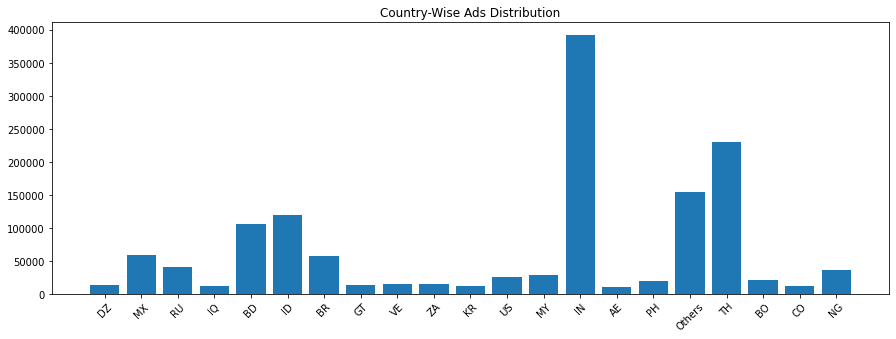

In [17]:
# bar plot of top countries
top_20_countries_df = top_20_countries.toPandas()
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
plt.title("Country-Wise Ads Distribution")
plt.bar(top_20_countries_df["country_modified"], top_20_countries_df["count(country_modified)"]);

----


#### `Make the transformation on the test data`

----

In [18]:
# validation data
valid_data = valid_data.withColumn("country_modified", map_countries_udf(valid_data["Country"]))
# test data
test_data = test_data.withColumn("country_modified", map_countries_udf(test_data["Country"]))

---

#### `Column - Traffic Type`

Now, let's explore the column `TrafficType` and we have already identified that it has 2 different categories. Let's find out the number of data points in each of the category.

---

In [19]:
# number of data points in each category and their percentage upto 4 decimal points
traffic_type = train_data.groupBy("TrafficType").agg(F.count("TrafficType").alias("count"),
                                                     F.round((F.count("TrafficType")/train_data.count())*100, 4).alias("percentage"))
traffic_type.show()

+-----------+------+----------+
|TrafficType| count|percentage|
+-----------+------+----------+
|       null|     0|       0.0|
|          M|370845|   26.4889|
|          A|828429|   59.1735|
+-----------+------+----------+



---

We also saw that the column `TrafficType` has 200726 missing values, almost 16 percent So, We will fill all those values with the `"U"` a third category which means unidentified. We will do this in the pre-processing stage where we will fill null values of all the required columns.

---

---

#### `Column - Fraud`

Now, let's explore the column `Fraud` and we have already identified that it has 2 different categories. Let's find out the number of data points in each of the category.

---

In [20]:
# number of data points in each category and their percentage upto 6 decimal points
fraud_type = train_data.groupBy("Fraud").agg(F.count("Fraud").alias("count"),
                                             F.round((F.count("Fraud")/train_data.count())*100, 6).alias("percentage"))
fraud_type.show()

+-----+-------+----------+
|Fraud|  count|percentage|
+-----+-------+----------+
|  0.0|1399992| 99.999429|
|  1.0|      8|   5.71E-4|
+-----+-------+----------+



---
---

#### `Column - Device`


Next, we will explore the Device column. We have already seen that, we have 764 devices in the dataset and this feature also has very high cardinality. So, we will have to reduce the number of the categories. Let's have a look at some of the top device categories in the dataset.

---

In [21]:
top_devices = train_data.groupBy("Device").agg(F.count("Device"))
top_devices.orderBy("count(Device)",ascending=False).show(20)

+--------+-------------+
|  Device|count(Device)|
+--------+-------------+
| Generic|       695723|
| Samsung|       197666|
|  Lenovo|        58867|
|     ZTE|        41291|
|Micromax|        40801|
| Alcatel|        40469|
|    Lava|        19338|
|Symphony|        19286|
|   Intex|        18600|
|      LG|        18216|
|    Sony|        14370|
|  Huawei|        13618|
|   Apple|        11467|
|     HTC|        10900|
|Motorola|        10492|
|    Asus|         9090|
|    true|         8232|
| Oukitel|         7395|
|   Tecno|         7300|
|  Gionee|         6887|
+--------+-------------+
only showing top 20 rows



----

Now, we can see the most of the devices are `Generic` and others are some brand names. We got `Generic` whenever we are unable to find out the brand of the device. So, we will create only 2 categories for this feature `Generic` and `Not Generic` and map them as 0 and 1.

Let's define a function to do the mapping.

----

In [22]:
# define the function to map the devices.
def map_device(x):
    if x not in ["Generic"]:
        return 0
    else:
        return 1

----

Convert to UDF function.

---

In [23]:
# convert tot udf function
map_device_udf = F.udf(f = map_device, returnType= tp.IntegerType())

---

Use the function `withColumn` & `map_device_udf` to map the device in the original data.


---

In [24]:
# map device
train_data = train_data.withColumn("device_modified", map_device_udf(train_data["Device"]))

----

Check the number of devices in each category `Generic` and `Not Generic`.

---

In [25]:
train_data.groupBy("device_modified").agg(F.count("device_modified")).show()

+---------------+----------------------+
|device_modified|count(device_modified)|
+---------------+----------------------+
|              1|                695723|
|              0|                704277|
+---------------+----------------------+



---

#### `Make the transformation on test data`

---

In [26]:
# map the device

# validation data
valid_data = valid_data.withColumn("device_modified", map_device_udf(valid_data["Device"]))
# test data
test_data = test_data.withColumn("device_modified", map_device_udf(test_data["Device"]))

---

#### `Column - Browser`

Now, let's explore the browser column We know that we have 30 different browsers in the dataset. Let's look at the numbers how many data points we have for each category of the Browser.


---

In [27]:
# each browser count in the dataset 
top_browser = train_data.groupBy("Browser").agg(F.count("Browser"))
top_browser.orderBy("count(Browser)",ascending=False).show(30)

+--------------------+--------------+
|             Browser|count(Browser)|
+--------------------+--------------+
|      android_webkit|        661313|
|              chrome|        584749|
|        46.0.2490.76|         91529|
|                  uc|         26155|
|            chromium|         11424|
|              iphone|         11070|
|               opera|          4405|
|              safari|           942|
|     firefox_desktop|           911|
|                msie|           690|
|            iemobile|           409|
|      firefox_mobile|           390|
|       tizen_browser|           227|
|             samsung|           223|
|          blackberry|           180|
|                 ovi|           130|
|              dorado|            79|
|              fennec|            37|
|         wap_browser|            23|
|            netfront|            12|
|        novarra_nweb|            11|
|             firefox|             6|
|             phantom|             6|
|dolfin/jasm

---

Now, we want to reduce the number of categories so we will club some of the categories as following:

> * **chrome** : `android_webkit`, `chrome`, `46.0.2490.76` (chrome version), `chromium`
> * **safari** : `iphone`, `safari`
> * **firefox** : `firefox_mobile`, `firefox`, `firefox_desktop` 
> * **others** : Rest of the Browsers



Let's define the function to map the browsers

---

In [28]:
# function to map the broswer
def map_browser(x):
    if x in ["android_webkit", "chrome", "46.0.2490.76", "chromium"]:
        return "chrome"
    
    elif x in ["iphone", "safari"]:
        return "safari"
    
    elif x in ["firefox_mobile", "firefox", "firefox_desktop"]:
        return "firefox"
    else:
        return "others"

---

Convert to udf function

---

In [29]:
# convert to udf function
map_browser_udf = F.udf(f = map_browser, returnType= tp.StringType())

---

Use the function `withColumn` & `map_browser_udf` to map the browser in the original data.

---

In [30]:
# update the column
train_data = train_data.withColumn("browser_modified", map_browser_udf(train_data["Browser"]))

---

Let's have a look at the number of data points with each category.

---

In [31]:
# data distribution of browser column
browser_distribution = train_data.groupBy("browser_modified").agg(F.count("browser_modified").alias("count")).show()
browser_distribution

+----------------+-------+
|browser_modified|  count|
+----------------+-------+
|         firefox|   1307|
|          chrome|1349015|
|          others|  37666|
|          safari|  12012|
+----------------+-------+



---

#### `Make the transformation on the test data.`


----

In [32]:
# reduce browser categories in the test and validation data 
# validation data
valid_data = valid_data.withColumn("browser_modified", map_browser_udf(valid_data["Browser"]))
# test data
test_data = test_data.withColumn("browser_modified", map_browser_udf(test_data["Browser"]))

---

#### `Column - OS`

---

Now, let's explore the OS column. We have 15 different OS in the dataset. Let's have a look at the number of data points and clicks for each category in the OS.


---

In [33]:
# groupby to find number of data points in each category of the OS
top_os = train_data.groupBy("OS").agg(F.count("OS"))
top_os.orderBy("count(OS)",ascending=False).show(23)

+----------------+---------+
|              OS|count(OS)|
+----------------+---------+
|         Android|  1377749|
|             iOS|    11398|
|         Desktop|     4589|
|Windows Phone OS|      931|
|           Tizen|      227|
|          RIM OS|      211|
|        Mac OS X|       61|
|         Xbox OS|       28|
|      Symbian OS|       14|
|      Firefox OS|        6|
|  PlayStation OS|        3|
|  MTK/Nucleus OS|        2|
|   RIM Tablet OS|        2|
|           MeeGo|        2|
|      Windows RT|        1|
|            null|        0|
+----------------+---------+



----


- We can observe here, that a majority of devices are from `Android`, so we can reduce the categories to either 2, `Android` or `Not Android`.
- But, let's keep some more. We will club `iOS` and `Mac OS X`. `Android` as a separate category and rest of the categories as `Others`.


Let's define a function to map the OS.

----

In [34]:
# define a function to map the OS.
def map_os(x):
    if x in ["Android"]:
        return "Android"
    
    elif x in ["iOS", "Mac OS X"]:
        return "ios"
    else:
        return "others"

---

Convert to UDF Function.

---

In [35]:
# convert the map_os
map_os_udf = F.udf(f= map_os, returnType= tp.StringType())

In [36]:
# modify the data using the withColumn and map_os_udf function
train_data = train_data.withColumn("modified_os", map_os_udf(train_data["OS"]))

---

Now, let's check the data points in updated categories of the OS column.

----

In [37]:
train_data.groupBy("modified_os").agg(F.count("modified_os")).show()

+-----------+------------------+
|modified_os|count(modified_os)|
+-----------+------------------+
|     others|             10792|
|    Android|           1377749|
|        ios|             11459|
+-----------+------------------+



---

#### `Make the transformation on the test data`

---

In [38]:
# validation dta
valid_data = valid_data.withColumn("modified_os", map_os_udf(valid_data["OS"]))
# test data
test_data = test_data.withColumn("modified_os", map_os_udf(test_data["OS"]))

----

#### `Column - Publisher ID`

---

Next, we will explore the publisherId.  Let's find out first how many different publisher we have in the dataset.


----

In [39]:
# distinct values in the publisherId
train_data.agg(F.countDistinct("publisherId")).show()

+---------------------------+
|count(DISTINCT publisherId)|
+---------------------------+
|                       2052|
+---------------------------+



---


Now, you must have noticed that `publisherId` column has the numeric data type. But these are different categories of the column. We cannot use this feature as a numeric one.

But we will use this column to create another feature: `frequency per publisher id`. For example, we have `publisher id: 50`

And id `50` is present in `45000` data points. 

So the frequency per publisher id for `id:50` is `45000`

---

To find out this we will first create a dataframe `total_p_id` which will have the total data points for each publisher id.

---

In [40]:
## groupby to calculate total data points for each publisher id.
total_p_id = train_data.groupBy("publisherId").agg(F.count("ConversionStatus").alias("total_p_id"))
total_p_id.show()

+-----------+----------+
|publisherId|total_p_id|
+-----------+----------+
|      37311|         8|
|       6240|        62|
|      42370|       105|
|      35640|         9|
|      37774|         1|
|      39457|         5|
|      39458|         9|
|      38223|         6|
|      31713|         1|
|      18314|         1|
|      39590|         1|
|      27884|         1|
|      39103|         1|
|      14157|         1|
|      36067|         1|
|        125|        63|
|      28524|        13|
|       9569|         6|
|      27339|        30|
|      17910|         2|
+-----------+----------+
only showing top 20 rows



---

Next, we will join this feature with the original train data.

---

In [41]:
# now, we will join this data with the original train data
train_data = train_data.join(total_p_id, on="publisherId")

In [42]:
train_data.select("publisherId", "total_p_id").show()

+-----------+----------+
|publisherId|total_p_id|
+-----------+----------+
|      14157|         1|
|      18314|         1|
|      27884|         1|
|      31713|         1|
|      35640|         9|
|      35640|         9|
|      35640|         9|
|      35640|         9|
|      35640|         9|
|      35640|         9|
|      35640|         9|
|      35640|         9|
|      35640|         9|
|      36067|         1|
|      37311|         8|
|      37311|         8|
|      37311|         8|
|      37311|         8|
|      37311|         8|
|      37311|         8|
+-----------+----------+
only showing top 20 rows



----

#### `Make the transformation on test data`

----

In [43]:
# now, we will join this data with the original test data

# validation
valid_data = valid_data.join(total_p_id, on="publisherId")
# test
test_data = test_data.join(total_p_id, on="publisherId")

---

#### `Column - Advertiser Campaign ID`


---

Now, we will explore the `Campaign ID` and find out the number of distinct values in it.

---

In [44]:
train_data.agg(F.countDistinct("advertiserCampaignId")).show()

+------------------------------------+
|count(DISTINCT advertiserCampaignId)|
+------------------------------------+
|                                 500|
+------------------------------------+



---

This feature is similar to the `publisherId` which looks numeric but actually categorical. So, we will do the same procedure as we did on the `publisherId`. And here we will calculate the `frequency per campaign id` 


First we will calculate the total data points for each campaign id.

---

In [45]:
## groupby to calculate total data points for each campaign id.
total_c_id = train_data.groupBy("advertiserCampaignId").agg(F.count("ConversionStatus").alias("total_c_id"))
total_c_id.show()

+--------------------+----------+
|advertiserCampaignId|total_c_id|
+--------------------+----------+
|             12671.0|       441|
|             14269.0|       344|
|             13607.0|        21|
|              4385.0|     12034|
|             13811.0|        58|
|              7791.0|      1782|
|             10130.0|        20|
|               735.0|     30971|
|             16800.0|        15|
|             14208.0|        59|
|             15823.0|        36|
|             12061.0|      6850|
|                 0.0|      2574|
|             14353.0|        15|
|             12555.0|        97|
|             15428.0|         3|
|             11830.0|      7719|
|             16060.0|      5624|
|             12690.0|        54|
|             16653.0|        25|
+--------------------+----------+
only showing top 20 rows



In [46]:
train_data = train_data.join(total_c_id, on="advertiserCampaignId")

In [47]:
train_data.select("advertiserCampaignId", "total_c_id").show()

+--------------------+----------+
|advertiserCampaignId|total_c_id|
+--------------------+----------+
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
|             12671.0|       441|
+--------------------+----------+
only showing top 20 rows



#### `Make the transformation on test data`

----

In [48]:
# validation data
valid_data = valid_data.join(total_c_id, on="advertiserCampaignId")
# test data
test_data = test_data.join(total_c_id, on="advertiserCampaignId")

---

## `BIVARIATE ANALYSIS`

---

#### `Number of Clicks for each category of Country`

---

In [49]:
# number of datapoints with each country
top_countries_with_clicks = train_data.groupBy("country_modified").agg(F.count("country_modified").alias("country_count"),
                                                                       F.sum("ConversionStatus").alias("number_of_clicks"))
top_countries_with_clicks.show()

+----------------+-------------+----------------+
|country_modified|country_count|number_of_clicks|
+----------------+-------------+----------------+
|              DZ|        13232|              12|
|              MX|        58908|              15|
|              IQ|        12581|               7|
|              RU|        41288|             103|
|              BD|       106338|             198|
|              ID|       119701|             113|
|              BR|        57664|              31|
|              GT|        13781|              10|
|              VE|        15405|               1|
|              ZA|        15835|              18|
|              KR|        12906|               0|
|              US|        26339|               6|
|              MY|        29340|              18|
|              IN|       391465|              82|
|              AE|        10512|               1|
|              PH|        19815|              15|
|          Others|       154135|              83|


In [50]:
# create new column of percentage of clicks
top_countries_with_clicks = top_countries_with_clicks.withColumn("percentage_of_clicks", (top_countries_with_clicks["number_of_clicks"]/top_countries_with_clicks["country_count"])*100)

In [51]:
# Sort the dataframe by percentage of clicks in descending order
top_countries_with_clicks= top_countries_with_clicks.orderBy("percentage_of_clicks", ascending = False).toPandas()
top_countries_with_clicks

,country_modified,country_count,number_of_clicks,percentage_of_clicks
0,RU,41288,103,0.249467
1,BD,106338,198,0.186199
2,NG,36244,53,0.146231
3,ZA,15835,18,0.113672
4,ID,119701,113,0.094402
5,DZ,13232,12,0.090689
6,PH,19815,15,0.075700
7,GT,13781,10,0.072564
8,MY,29340,18,0.061350
9,IQ,12581,7,0.055639


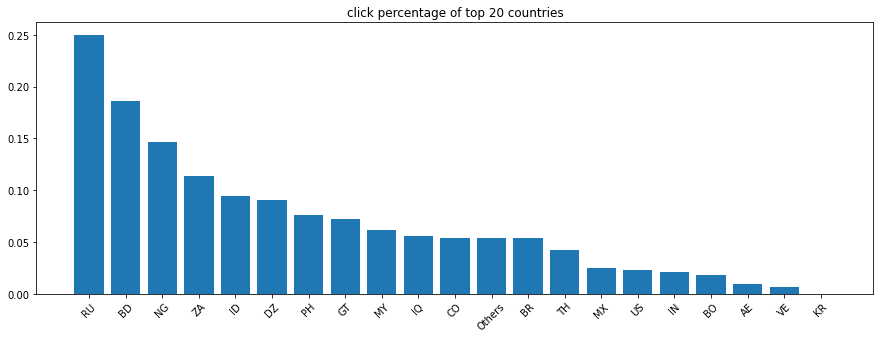

In [52]:
# bar plot of top countries
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
plt.title("click percentage of top 20 countries")
plt.bar(top_countries_with_clicks["country_modified"], top_countries_with_clicks["percentage_of_clicks"]);

---

Here, we can see that top 4 countries have atleast 0.1 percent of click rate. Sp, you can also further reduce the categories upto 4 and map rest of them as Others. For now, we are going ahead with the 21 categories in the country column.

---

#### `Number of Clicks for each category of Browser`

---

In [53]:
# number of datapoints with each country
top_browsers_with_clicks = train_data.groupBy("browser_modified").agg(F.count("browser_modified").alias("browser_count"),
                                                                       F.sum("ConversionStatus").alias("number_of_clicks"))
top_browsers_with_clicks.show()

+----------------+-------------+----------------+
|browser_modified|browser_count|number_of_clicks|
+----------------+-------------+----------------+
|         firefox|         1307|               0|
|          chrome|      1349014|             859|
|          others|        37662|              12|
|          safari|        12012|               3|
+----------------+-------------+----------------+



---

It is very clear from the above data, that almost 99.9 percent of the clicks are coming from the `chrome` browser So, you also reduce the categories to 2 only, `chrome` and `not chrome`.

---

#### `Number of Clicks for each category of Device`

---

In [54]:
# number of datapoints with each country
top_devices_with_clicks = train_data.groupBy("device_modified").agg(F.count("device_modified").alias("device_count"),
                                                                    F.sum("ConversionStatus").alias("number_of_clicks"))
top_devices_with_clicks.show()

+---------------+------------+----------------+
|device_modified|device_count|number_of_clicks|
+---------------+------------+----------------+
|              1|      695722|             419|
|              0|      704273|             455|
+---------------+------------+----------------+



---

It is almost the same number of clicks in both the categories.

---

### `Number of Clicks for each catefory of OS`

---

In [55]:
# number of datapoints and clicks for each os
top_os_with_clicks = train_data.groupBy("modified_os").agg(F.count("modified_os").alias("os_count"),
                                                           F.sum("ConversionStatus").alias("number_of_clicks"))
top_os_with_clicks.show()

+-----------+--------+----------------+
|modified_os|os_count|number_of_clicks|
+-----------+--------+----------------+
|     others|   10792|               4|
|    Android| 1377744|             868|
|        ios|   11459|               2|
+-----------+--------+----------------+



---

We can see that from the above data, that most of the ads clicked from the `Android` os, so we can also reduce the categories to 2 only, `Android` and `Not Android`.

---

### `Summary of Data Exploration`

- Most number of Ads were shown in the country `IN` and highest percentage of Ads were clicked in `RU`.
- More than 98 percent of the devices are running on `Android` os.

---

## `Pre-Processing`

---

- We will fill the Null Values.
- We will do label-encoding the categorical variable.
- We will do one-hot encoding the categorical variables.


---

---

#### `Fill Null Values`
---

We will fill the null values with the following values.


- **`Country`** with **`IN`**: As most of the Ads were shown in this country.
- **`TrafficType`** with **`U`**: `U` means unidentified, we have discussed this in the exploration part.
- **`Device`** with **`1`**: `Generic` for 1 as they are unidentified devices.
- **`Broswer`** with **`chrome`**: As most of the data points have `chrome` browser.
- **`OS`** with **`Android`**: As most of the data points have `Android` OS.
- **`total_c_id`** with 0:  As for the new campaigns which comes in future, we have no data.
- **`total_p_id`** with 0:  As for the new campaigns which comes in future, we have no data.

---

In [56]:
# fill null values in the train data
train_data = train_data.fillna({
            "Fraud" : 0,
            "country_modified": "IN",
            "TrafficType" : "U",
            "device_modified": 1,
            "browser_modified": "chrome",
            "modified_os": "Android",
            "total_c_id" : 0,
            "total_p_id" : 0
        })

In [57]:
# fill null values in the test data
test_data = test_data.fillna({
            "Fraud" : 0,
            "country_modified": "IN",
            "TrafficType" : "U",
            "device_modified": 1,
            "browser_modified": "chrome",
            "modified_os": "Android",
            "total_c_id" : 0,
            "total_p_id" : 0
        })

# fill null values in the test data
valid_data = valid_data.fillna({
            "Fraud" : 0,
            "country_modified": "IN",
            "TrafficType" : "A",
            "device_modified": 1,
            "browser_modified": "chrome",
            "modified_os": "Android",
            "total_c_id" : 0,
            "total_p_id" : 0
        })

---

#### `Encoding Categorical Variables`

Categorical values need to be encoded or converted to numeric form before inputting it to an ML model.

Two ways of encoding categorical values:

**Label Encoding**

   > Assigning a unique integer to each of the categorical values
   > Done using StringIndexer

![](images/module_12_pre_processing_le.png)



**One Hot Encoding**

   > New columns created for each of the unique value in categorical column. Values assigned 0 or 1 based on the presence of the data.
   > Requires features to be label encoded first.
   > Done using OneHotEncoderEstimator
    
![](images/module_12_pre_processing_ohe.png)


----

We will do the following encoding of the categorical variables in this notebook.

 - Country (One Hot Encode)
 - Traffic (One Hot Encode) 
 - Browser (One Hot Encode)
 - OS      (One Hot Encode)    
 
    
    
---

#### `Importing the Required Libraries`

---

In [58]:
# importing some more libraries
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator

---

#### `Creating the StringIndexer Objects`

---

In [59]:
# label encode country
SI_Country = StringIndexer(inputCol= "country_modified", outputCol= "country_le" , handleInvalid="skip")

# label encode browser
SI_Browser = StringIndexer(inputCol= "browser_modified", outputCol= "browser_le", handleInvalid= "skip")

# label encode os
SI_OS      = StringIndexer(inputCol= "modified_os",      outputCol= "os_le", handleInvalid= "skip")

# label encode traffic
SI_Traffic = StringIndexer(inputCol= "TrafficType", outputCol= "traffic_le", handleInvalid="skip")

---

#### `Fit the StringIndexer Objects`

---

In [60]:
# label encode object country
SI_Country_Obj = SI_Country.fit(train_data)

# label encode object browser
SI_Browser_Obj = SI_Browser.fit(train_data)

# label encode object os
SI_OS_Obj = SI_OS.fit(train_data)

# label encode object traffic
SI_Traffic_Obj = SI_Traffic.fit(train_data)

---

#### `Transform the StringIndexer Objects`

----

In [61]:
# label encode country
train_data_encoded = SI_Country_Obj.transform(train_data)

# label encode browser
train_data_encoded = SI_Browser_Obj.transform(train_data_encoded)

# label encode os
train_data_encoded = SI_OS_Obj.transform(train_data_encoded)

# label encode traffic
train_data_encoded = SI_Traffic_Obj.transform(train_data_encoded)

----

#### `Make the Transformation on the test data`

---

In [62]:
# label encode country

# validation data
valid_data_encoded = SI_Country_Obj.transform(valid_data)
# test data
test_data_encoded = SI_Country_Obj.transform(test_data)


# label encode browser

# validation data
valid_data_encoded = SI_Browser_Obj.transform(valid_data_encoded)
# test data
test_data_encoded = SI_Browser_Obj.transform(test_data_encoded)

# label encode os

# validation data
valid_data_encoded = SI_OS_Obj.transform(valid_data_encoded)
# test data
test_data_encoded = SI_OS_Obj.transform(test_data_encoded)

# label encode traffic

# validation data
valid_data_encoded = SI_Traffic_Obj.transform(valid_data_encoded)
test_data_encoded = SI_Traffic_Obj.transform(test_data_encoded)

In [63]:
# let's check the columns in the data
train_data_encoded.columns

['advertiserCampaignId',
 'publisherId',
 'ID',
 'Country',
 'Carrier',
 'TrafficType',
 'ClickDate',
 'Device',
 'Browser',
 'OS',
 'ConversionStatus',
 'Fraud',
 'country_modified',
 'device_modified',
 'browser_modified',
 'modified_os',
 'total_p_id',
 'total_c_id',
 'country_le',
 'browser_le',
 'os_le',
 'traffic_le']

---

### `ONE-HOT ENCODING`

---

---

Next, we will create the object of the `OneHotEncoderEstimator` and pass the input and output columns list.

---

In [64]:
OHE_train = OneHotEncoderEstimator(inputCols=["country_le",
                                              "browser_le",
                                              "os_le",
                                              "traffic_le"],
                                  outputCols=["country_ohe",
                                              "browser_ohe",
                                              "os_ohe",
                                              "traffic_ohe"])

---

Fit & Transform the data.

---

In [65]:
# OHE object
OHE_Obj = OHE_train.fit(train_data_encoded)

In [66]:
# Transform train data
train_data_encoded = OHE_Obj.transform(train_data_encoded)

In [67]:
# view the one hot encoded data
train_data_encoded.select("ID",
                          "country_modified", 
                          "country_ohe",
                          "browser_modified",
                          "browser_ohe",
                          "modified_os",
                          "os_ohe").show()

+-------+----------------+--------------+----------------+-------------+-----------+-------------+
|     ID|country_modified|   country_ohe|browser_modified|  browser_ohe|modified_os|       os_ohe|
+-------+----------------+--------------+----------------+-------------+-----------+-------------+
|1525010|              IN|(20,[0],[1.0])|          chrome|(3,[0],[1.0])|    Android|(2,[0],[1.0])|
| 176007|              IN|(20,[0],[1.0])|          chrome|(3,[0],[1.0])|    Android|(2,[0],[1.0])|
|1772096|              IN|(20,[0],[1.0])|          chrome|(3,[0],[1.0])|    Android|(2,[0],[1.0])|
|1811022|              IN|(20,[0],[1.0])|          chrome|(3,[0],[1.0])|    Android|(2,[0],[1.0])|
|1633774|              IN|(20,[0],[1.0])|          chrome|(3,[0],[1.0])|    Android|(2,[0],[1.0])|
|1706800|              IN|(20,[0],[1.0])|          chrome|(3,[0],[1.0])|    Android|(2,[0],[1.0])|
| 192711|              IN|(20,[0],[1.0])|          chrome|(3,[0],[1.0])|    Android|(2,[0],[1.0])|
|1144160| 

----

#### `Make the transformation on test data`

----

In [68]:
# transform the data

# validation data
valid_data_encoded = OHE_Obj.transform(valid_data_encoded)
# test data
test_data_encoded = OHE_Obj.transform(test_data_encoded)

---


## `MODEL BUILDING`

Now, we have prepared the dataset and it is ready to be trained with Machine Learning models. This is a `Classification Problem`, so we will train the data on the following alogrithms.

 * **Logistic Regression**
 * **Decision Tree Classification**



---

---

#### `VECTOR ASSEMBLER`

- Before passing the data into the ML model, we need to convert the required features into a Vector. We can do this using a `VectorAssembler`.
---

In [69]:
## columns in the dataset
train_data_encoded.columns

['advertiserCampaignId',
 'publisherId',
 'ID',
 'Country',
 'Carrier',
 'TrafficType',
 'ClickDate',
 'Device',
 'Browser',
 'OS',
 'ConversionStatus',
 'Fraud',
 'country_modified',
 'device_modified',
 'browser_modified',
 'modified_os',
 'total_p_id',
 'total_c_id',
 'country_le',
 'browser_le',
 'os_le',
 'traffic_le',
 'country_ohe',
 'browser_ohe',
 'os_ohe',
 'traffic_ohe']

---

#### `Define the VectorAssembler Object`

---

----

So, now we will select the features and create a vector using `VectorAssembler`

 * traffic (One Hot Encoded)
 * Fraud   (As it is)
 * total_p_id (Feature Created: Frequency per Publisher id)
 * total_c_id (Feature Created: Frequency per Campaign Id)
 * country_ohe (One Hot Encoded)
 * device_modified (Label Encoded)
 * browser_ohe (One Hot Encoded)
 * os_ohe (One Hot Encoded)

----

In [70]:
# import the library
from pyspark.ml.feature import VectorAssembler

# create feature vector
feature_vector = VectorAssembler(inputCols= ['traffic_ohe',
                                             'Fraud',
                                             'total_p_id',
                                             'total_c_id',
                                             'country_ohe',
                                             'device_modified',
                                             'browser_ohe',
                                             'os_ohe'],
                                outputCol= 'feature_vector')

---

`TRANSFORM THE FEATURE VECTOR`

----

In [71]:
# transform the feature vector
train_data_encoded = feature_vector.transform(train_data_encoded)

In [72]:
# view the feature vector
train_data_encoded.select("feature_vector").show(10)

+--------------------+
|      feature_vector|
+--------------------+
|(31,[0,3,4,5,25,2...|
|(31,[0,3,4,5,26,2...|
|(31,[0,3,4,5,25,2...|
|(31,[0,3,4,5,26,2...|
|(31,[0,3,4,5,25,2...|
|(31,[0,3,4,5,26,2...|
|(31,[0,3,4,5,26,2...|
|(31,[0,3,4,5,25,2...|
|(31,[0,3,4,5,26,2...|
|(31,[0,3,4,5,26,2...|
+--------------------+
only showing top 10 rows



In [73]:
# we can see that the data type of the `feature_vector` is vector
train_data_encoded.printSchema()

root
 |-- advertiserCampaignId: double (nullable = true)
 |-- publisherId: string (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Carrier: double (nullable = true)
 |-- TrafficType: string (nullable = false)
 |-- ClickDate: timestamp (nullable = true)
 |-- Device: string (nullable = true)
 |-- Browser: string (nullable = true)
 |-- OS: string (nullable = true)
 |-- ConversionStatus: integer (nullable = true)
 |-- Fraud: double (nullable = false)
 |-- country_modified: string (nullable = false)
 |-- device_modified: integer (nullable = false)
 |-- browser_modified: string (nullable = false)
 |-- modified_os: string (nullable = false)
 |-- total_p_id: long (nullable = false)
 |-- total_c_id: long (nullable = false)
 |-- country_le: double (nullable = false)
 |-- browser_le: double (nullable = false)
 |-- os_le: double (nullable = false)
 |-- traffic_le: double (nullable = false)
 |-- country_ohe: vector (nullable = true)
 |-- browser_ohe: 

----

#### `Make the transformation on test data.`

----

In [74]:
# transform the feature vector

# validation data
valid_data_encoded = feature_vector.transform(valid_data_encoded)
# test data
test_data_encoded = feature_vector.transform(test_data_encoded)

---

#### `LOGISTIC REGRESSION`

First, we will train the model with the Logistic Regression and see the `AOC-ROC`.

For that let's import some more libraries.

----

In [75]:
# importing the libraries
from pyspark.ml import classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator

---

First we will create the Logistic Regression and pass the `feature vector` and the label column which is `ConversionStatus`

---

In [76]:
model_LR = classification.LogisticRegression(featuresCol='feature_vector', labelCol="ConversionStatus")

---


Fit the model

---

In [77]:
model_LR = model_LR.fit(train_data_encoded)

---

Next, we will use the `BinaryClassificationEvaluator` to calculate the `AUC-ROC score` and for that we have to pass the `labelCol: ConversionStatus` and the `metricName: areaUnderROC`

---

In [78]:
# Evaluate training data
evaluator = BinaryClassificationEvaluator(labelCol="ConversionStatus", metricName="areaUnderROC") 
evaluator.evaluate(model_LR.transform(train_data_encoded)) 

0.7376408496503599

---

So, we got the`ROC`: 0.7377




---

In [79]:
# Evaluate validation data
evaluator.evaluate(model_LR.transform(valid_data_encoded))

0.6925886389513927

---

#### `DECISION TREE CLASSIFIER`


Next, we will train the decision tree classifier model and do the same steps as we did with the logistic regression.

---

In [80]:
# create object of DecisionTreeClassifier
model_DTR = classification.DecisionTreeClassifier(featuresCol= "feature_vector",  labelCol="ConversionStatus")

In [81]:
# fit the model
model_DTR = model_DTR.fit(train_data_encoded)

In [82]:
# evaluate the model
evaluator.evaluate(model_DTR.transform(train_data_encoded))

0.5

So, the `ROC: 0.5` which means that Logistic Regression was better than Decision Tree.


---

In [83]:
# Evaluate on validation data
evaluator.evaluate(model_DTR.transform(valid_data_encoded))

0.5

----

#### `RANDOM FOREST CLASSIFIER`

---

##### `EXERCISE`

----

In [84]:
# write your code here

---

# `Model Tuning`

* **Cross-Validation**
* **Grid-Search**

---

---

So far, we saw the `Logistic Regression` and `Decision Tree` algorithms. But we were running them using the default parameters only. So, we will tune the parameters of our model and see if it gets any better. 

First we, will do the cross validation

---

## `CROSS VALIDATION`




Let's see how to do the cross validation.

![](images/module_12_tuning_cross_val.png)


---

In [85]:
# import the CrossValidator and ParamGridBuilder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [86]:
# create the ParamGridBuilder
params = ParamGridBuilder().build()

In [87]:
# create the object of the Logistic Regression Model
model_LR_CV = classification.LogisticRegression(featuresCol= "feature_vector",  labelCol="ConversionStatus")

In [88]:
# create object of the cross validation model with numFolds = 3
cv = CrossValidator(estimator=model_LR_CV,
                    estimatorParamMaps=params,
                    evaluator=evaluator,
                    numFolds=3,
                    seed=27)

---

#### `FIT THE MODEL`

---

In [89]:
## fit the model
cv_model = cv.fit(train_data_encoded)

In [90]:
# evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="ConversionStatus",metricName="areaUnderROC") 
evaluator.evaluate(cv_model.transform(train_data_encoded)) 

0.7378537881835213

In [91]:
# evaluate model on validation data
evaluator.evaluate(cv_model.transform(valid_data_encoded))

0.6927723920753124

---


## `GRID SEARCH`

Next, we will try the Grid Search where it will apply different combinations of parameter to give you the best model.

---

![](images/module_12_tuning_grid_search.png)

---

In [92]:
# create parameter builder

updated_params = ParamGridBuilder() \
                .addGrid(model_LR_CV.regParam, [0.01, 0.005, 0.0001]) \
                .addGrid(model_LR_CV.elasticNetParam, [0.1, 0.001]) \
                .build()

In [93]:
# create object of the Cross Calidator with 3 folds
cv = CrossValidator(estimator=model_LR_CV,
                    estimatorParamMaps=updated_params,
                    evaluator=evaluator,
                    numFolds=3,
                    seed=27)

In [94]:
# fit the model
grid_model = cv.fit(train_data_encoded)

In [95]:
# evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="ConversionStatus",metricName="areaUnderROC") 
evaluator.evaluate(grid_model.transform(train_data_encoded))

0.7374950078373576

In [96]:
# evaluate model on validation data
evaluator.evaluate(grid_model.transform(valid_data_encoded))

0.6916072648769976

---

Get the best model parameters.

---

In [97]:
# extract the best model parameters dictionary
param_dict = grid_model.bestModel.extractParamMap()

In [98]:
param_dict

{Param(parent='LogisticRegression_8d2d271dff16', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_8d2d271dff16', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.001,
 Param(parent='LogisticRegression_8d2d271dff16', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_8d2d271dff16', name='featuresCol', doc='features column name'): 'feature_vector',
 Param(parent='LogisticRegression_8d2d271dff16', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_8d2d271dff16', name='labelCol', doc='label column name'): 'ConversionStatus',
 Param(parent='LogisticRegression_8d2d271dff16', name='maxIter', doc='maximum number of it

In [99]:
# created a filtered dictionary
final_dict = {}
for k, v in param_dict.items():
    final_dict[k.name] = v

In [100]:
# get the best elastic net parameter
final_dict["elasticNetParam"]

0.001

In [101]:
# get the best regularization parameter
final_dict["regParam"]

0.0001


----
----


### `Machine Learning Pipelines in Spark`

----


 *   `Transformer` 
 > - It transforms the input data (X) in some ways.
 > - Implements a method `transform()`, which converts one DataFrame into another, generally by appending one or more columns.
 > - It includes `feature transformers` and `learned models`.
 > > - `Feature transformer` should take a DataFrame, read a column (e.g., text), map it into a new column (e.g., feature vectors), and output a new DataFrame with the mapped column appended.
 > > -  `Learning model` should take a DataFrame, read the column containing feature vectors, predict the label for each feature vector, and output a new DataFrame with predicted labels appended as a column.
 *   `Estimator` 
 > - It predicts a new value (or values) (y) by using the input data (X).
 > - It implements a method `fit()`, which accepts a DataFrame and produces a `Model`, which is a `Transformer`.
 > > - For example, a learning algorithm such as `LogisticRegression` is an `Estimator`, and calling `fit()` trains a `LogisticRegressionModel`, which is a `Model` and hence a `Transformer`.
 * `Pipeline`
 > - It represents a sequence of steps to apply in an ML workflow. Example:
 > > - Stage 1 : Split text into words.
 > > - Stage 2 : Convert words into numeric data.
 > > - Stage 3 : Apply machine learning model on the numeric data.
 > - These steps are represented as `Transformers` or as `Estimators`.
 > - A `Pipeline` is comprised of `Stages`.
 > > - These stages are run in order.
 > > - The input DataFrame is transformed as it passes through each stage.
 > > - Each stage is either a `Transformer` or an `Estimator`.
 
 ---
 
**`Import the Required Libraries`**
 
 ---

In [102]:
## Import the Required Libraries 
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.ml import classification

---
#### **`Creating a Sample Dataframe`**

---

In [103]:
# Create a sample dataframe
sample_df = spark.createDataFrame([
                                    (1, 'L101', 'R'),
                                    (2, 'L201', 'C'),
                                    (3, 'D111', 'R'),
                                    (4, 'F210', 'R'),
                                    (5, 'D110', 'C')
                                ], 
                                ['id', 'category_1', 'category_2'])

In [104]:
# Display dataset
sample_df.show()

+---+----------+----------+
| id|category_1|category_2|
+---+----------+----------+
|  1|      L101|         R|
|  2|      L201|         C|
|  3|      D111|         R|
|  4|      F210|         R|
|  5|      D110|         C|
+---+----------+----------+



---

#### **`Defining the different Stages of the Pipeline`**

---

We have created the dataframe. Suppose we have to transform the data in the below order:

   * **stage_1:** Label Encode or String Index the column category_1
   * **stage_2:** Label Encode or String Index the column category_2
   * **stage_3:** One-Hot Encode the indexed column category_2
   
---   
   
![](images/pipeline_sample.png)


---

In [105]:
# Define stage 1 : Label Encode category_1
stage_1 = StringIndexer(inputCol= 'category_1', outputCol= 'category_1_index')

# Define stage 2 : Label Encode category_2
stage_2 = StringIndexer(inputCol= 'category_2', outputCol= 'category_2_index')

# Define stage 3 : One-Hot Encode label encoded category_2
stage_3 = OneHotEncoderEstimator(inputCols= ['category_2_index'], outputCols= ['category_2_OHE'])

---
#### **Defining the Pipeline**

All stages to be applied are listed in the Pipeline object.

---

In [106]:
# Setup the pipeline object with the three stages
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3])

----

#### **`Fit` and `Transform` the Pipeline**

---

In [107]:
# Fit the Pipeline model on the dataframe
pipeline_model = pipeline.fit(sample_df)

In [108]:
# Transform the dataframe
sample_df_updated = pipeline_model.transform(sample_df)

In [109]:
# View the transformed data
sample_df_updated.show()

+---+----------+----------+----------------+----------------+--------------+
| id|category_1|category_2|category_1_index|category_2_index|category_2_OHE|
+---+----------+----------+----------------+----------------+--------------+
|  1|      L101|         R|             4.0|             0.0| (1,[0],[1.0])|
|  2|      L201|         C|             1.0|             1.0|     (1,[],[])|
|  3|      D111|         R|             3.0|             0.0| (1,[0],[1.0])|
|  4|      F210|         R|             0.0|             0.0| (1,[0],[1.0])|
|  5|      D110|         C|             2.0|             1.0|     (1,[],[])|
+---+----------+----------+----------------+----------------+--------------+



---


We have three new columns containing output from the three stages.

---
#### **Creating Custom Transformer**

We can also create custom transformers to accomplish tasks that are not present in Spark ML by default. For example, we can create a custom transformer for replacing `null` values in the dataframe.

Let's create a sample dataframe with some `null` values.

---

In [110]:
# Create a sample dataframe
sample_df = spark.createDataFrame([
                                    (1, 'L101', None),
                                    (2, 'L201', 'C'),
                                    (3, 'D330', None),
                                    (4, 'F212', None),
                                    (5, 'D110', 'C')
                                  ], ['id', 'category_1', 'category_2'])

In [111]:
# View dataframe
sample_df.show()

+---+----------+----------+
| id|category_1|category_2|
+---+----------+----------+
|  1|      L101|      null|
|  2|      L201|         C|
|  3|      D330|      null|
|  4|      F212|      null|
|  5|      D110|         C|
+---+----------+----------+



**Define the custom transformer class to do the following:**
- Replace null values with provided values.

In [112]:
# Custom transformer class
# Inherit Transformer, HasInputCol parent classes
class customTransformer(Transformer, HasInputCol):
  
    # Class constructor
    def __init__(self, inputCol= None, fill_with = None):
        
        # input columns
        self.inputCol  = inputCol
        
        # null value replacements
        self.fill_with = fill_with

    
    # Define custom transformer
    def _transform(self, dataset):
        
        # Replace null values in the passed dataframe 
        dataset = dataset.fillna({self.inputCol : self.fill_with})
    
        return dataset

Now that we have created a custom transformer, we can apply this transformer to 

In [113]:
# Define custom trasnformer object
s1 = customTransformer(inputCol= "category_2", 
                       fill_with= "A")

In [114]:
# Create pipeline object with the custom trasnformer stage
p = Pipeline(stages=[s1])

In [115]:
# Fit pipeline on the dataframe
custom_pipeline = p.fit(sample_df)

In [116]:
# View updated dataframe
transformed_df = custom_pipeline.transform(sample_df)

In [117]:
transformed_df.show()

+---+----------+----------+
| id|category_1|category_2|
+---+----------+----------+
|  1|      L101|         A|
|  2|      L201|         C|
|  3|      D330|         A|
|  4|      F212|         A|
|  5|      D110|         C|
+---+----------+----------+



- `null` values in `category_2` column have been replaced with `A`.
- New column `transformed` has been formed with the numeric mappings.

---

## `Click Prediction - Pipelines`

---

---

#### `LOAD THE DATASET`

---

In [118]:
train_data_pipeline = spark.read.csv("Spark_ML_Project/dataset/train.csv", inferSchema=True, header=True)
valid_data_pipeline =  spark.read.csv("Spark_ML_Project/dataset/valid.csv", inferSchema=True, header=True)
test_data_pipeline = spark.read.csv("Spark_ML_Project/dataset/test.csv", inferSchema=True, header=True)

In [119]:
train_data_pipeline = train_data_pipeline.withColumn("ConversionStatus", F.col("ConversionStatus").cast(tp.IntegerType()))

---
### `Define the stages of the Pipeline`

  * **STAGE 1**: [Transformer] Fill null values with in each column
  * **STAGE 2**: [Transformer] Reduce Category
  * **STAGE 3**: [Estimator] Label Encode: Traffic
  * **STAGE 4**: [Estimator] Label Encode: Country
  * **STAGE 5**: [Estimator] Label Encode: Browser
  * **STAGE 6**: [Estimator] Label Encode: OS
  * **STAGE 7**: [Estimator] OHE: Country, Browser, OS
  * **STAGE 8**: [Transformer] Create Feature: Total Click per Publisher ID, Total Click per Campaign ID
  * **STAGE 9**: Transformer] Create Vector [ Traffic (LE), Fraud, Average_Click per Puplisher ID, Average Click per Campaign ID, Country (OHE), Browser (OHE), Device (OHE), OS (OHE)]
  * **STAGE 10**: [Estimator] Predict Labels Using the Logistic Regression





---
#### **`Define Custom Transformers`**

* Custom transformer to fill null values
* Custom transformer to reduce categories
* Custom transformer to create features

----
#### `Custom Transformer to fill Null Values`

* Fill null value with mode from respective column.
---

In [120]:
# custom transformer to fill null values

class nullValuesTransformer(Transformer):
    
    def __init__(self, dataframe = None):
        self.dataframe = dataframe
    
    def _transform(self, dataframe):
        dataframe = dataframe.fillna({
            "Fraud" : 0,
            "Country": "IN",
            "TrafficType" : "U",
            "Device": "Generic",
            "Browser": "chrome",
            "OS": "Android",
        })
        
        return dataframe

---

#### `Custom Transformer to reduce categories`

* Reduce categories for - Country, Device, Browser, OS
---

In [121]:
# Creating custom Transformer to reduce the categories of multiple features
class reduceCategories(Transformer):
    
    def __init__(self, dataframe = None):
        self.dataframe = dataframe
        
    def _transform(self, dataframe):
        
        # map the countries
        dataframe = dataframe.withColumn("country_modified", map_countries_udf(dataframe["Country"]))
        
         # map device
        dataframe = dataframe.withColumn("device_modified", map_device_udf(dataframe["Device"]))
        
        # map browser
        dataframe = dataframe.withColumn("browser_modified", map_browser_udf(dataframe["Browser"]))

        # map the os
        dataframe = dataframe.withColumn("os_modified", map_os_udf(dataframe["OS"]))
        
        return dataframe

---

#### `Custom Transformer to create features`

* Total clicks per Campaign ID
* Total clicks per Publisher ID
---

In [122]:
# Creating two new features: total clicks per campaign Id, total clicks per publisher Id
class frequencyEncoding(Transformer):
    
    def __init__(self, dataframe = None):
        self.dataframe = dataframe
        
    def _transform(self, dataframe):
        
        # join total clicks per advertiser Campaign Id
        dataframe = dataframe.join(total_c_id, on="advertiserCampaignId")
        
        # join total clicks per publisher id dataframe
        dataframe = dataframe.join(total_p_id, on="publisherId")
        
        # replace null values
        dataframe = dataframe.fillna({
            'total_p_id': 0.0,
            'total_c_id' : 0.0,
        })
        
        return dataframe
        

---


#### **`Define the Stages`**

---

In [123]:
# Stage 1 - replace null values
stage_1 = nullValuesTransformer()

# stage 2 - reduce categories
stage_2 = reduceCategories()

# Stage 3 - label encode Traffic_Type column
stage_3 = StringIndexer(inputCol= "TrafficType", outputCol= "traffic_le") 

# Stage 4 - label encode Country column
stage_4 = StringIndexer(inputCol= "country_modified", outputCol= "country_le")

# Stage 5 - label encode Browser column
stage_5 = StringIndexer(inputCol= "browser_modified", outputCol= "browser_le")

# Stage 6 - label encode OS column
stage_6 = StringIndexer(inputCol= "os_modified", outputCol= "os_le")

 # Stage 7 - One Hot Encode columns
stage_7 = OneHotEncoderEstimator(inputCols= ["country_le",  "browser_le", "os_le", "traffic_le"], 
                        outputCols= ["country_ohe",  "browser_ohe", "os_ohe", "traffic_ohe"])

# stage 8 - Create new features for total clicks per campaign id and per pulisher id
stage_8 = frequencyEncoding()

# Stage 9 - Create vector from the columns
stage_9 = VectorAssembler(inputCols= ["Fraud",
                                      "traffic_ohe",
                                      "country_ohe",
                                      "device_modified",
                                      "browser_ohe",
                                      "os_ohe",
                                      'total_p_id',
                                      'total_c_id',],

                         outputCol=  "feature_vector")

# Stage 10 - Train ML model
stage_10 = classification.LogisticRegression(featuresCol= "feature_vector", labelCol= "ConversionStatus")

---

#### **`Define the Pipeline`**

----

In [124]:
# Define pipeline
pipeline = Pipeline(stages= [stage_1,
                             stage_2,
                             stage_3,
                             stage_4,
                             stage_5,
                             stage_6,
                             stage_7,
                             stage_8,
                             stage_9,
                             stage_10])

---

### `FIT AND TRANSFORM THE PIPELINE`

---

In [125]:
# fit the pipeline with the training data
pipeline_model = pipeline.fit(train_data_pipeline)

# transform data
final_data = pipeline_model.transform(train_data_pipeline)

In [126]:
final_data.select("ID", "ConversionStatus", "rawPrediction", "probability", "prediction").show(10)

+-------+----------------+--------------------+--------------------+----------+
|     ID|ConversionStatus|       rawPrediction|         probability|prediction|
+-------+----------------+--------------------+--------------------+----------+
|1149677|               0|[7.21822491516255...|[0.99926743446182...|       0.0|
|1244757|               0|[6.80345070629307...|[0.99889129213711...|       0.0|
|1043606|               0|[6.93796492209716...|[0.99903069834962...|       0.0|
|1984593|               0|[7.14197862531680...|[0.99920944039110...|       0.0|
| 576666|               0|[7.00502755266701...|[0.99909351352712...|       0.0|
| 207309|               0|[7.00502755266701...|[0.99909351352712...|       0.0|
| 953682|               0|[7.00502755266701...|[0.99909351352712...|       0.0|
|1340626|               0|[7.01222040768815...|[0.99910000451238...|       0.0|
| 410875|               0|[7.00502755266701...|[0.99909351352712...|       0.0|
|1102275|               0|[7.01222040768

---

#### `TRANSFORM THE VALIDATION DATA`

---

In [127]:
final_valid_data = pipeline_model.transform(valid_data_pipeline)

In [128]:
final_valid_data.columns

['publisherId',
 'advertiserCampaignId',
 'ID',
 'Country',
 'Carrier',
 'TrafficType',
 'ClickDate',
 'Device',
 'Browser',
 'OS',
 'ConversionStatus',
 'Fraud',
 'country_modified',
 'device_modified',
 'browser_modified',
 'os_modified',
 'traffic_le',
 'country_le',
 'browser_le',
 'os_le',
 'country_ohe',
 'browser_ohe',
 'os_ohe',
 'traffic_ohe',
 'total_c_id',
 'total_p_id',
 'feature_vector',
 'rawPrediction',
 'probability',
 'prediction']

In [129]:
final_valid_data.select("ID", "ConversionStatus", "rawPrediction", "probability", "prediction").show(10)

+-------+----------------+--------------------+--------------------+----------+
|     ID|ConversionStatus|       rawPrediction|         probability|prediction|
+-------+----------------+--------------------+--------------------+----------+
|1777264|           false|[8.16490777138877...|[0.99971561801155...|       0.0|
| 384588|           false|[8.16672012629907...|[0.99971613279971...|       0.0|
| 206936|           false|[5.946353857582,-...|[0.99739146313408...|       0.0|
| 555122|           false|[5.95354671260314...|[0.99741011022462...|       0.0|
| 916258|           false|[7.20258003808803...|[0.99925589203769...|       0.0|
| 247351|           false|[6.65166829846339...|[0.99870980167203...|       0.0|
|1047148|           false|[7.20977289310918...|[0.99926122115549...|       0.0|
|1295510|           false|[7.20258003808803...|[0.99925589203769...|       0.0|
| 764131|           false|[5.95354671260314...|[0.99741011022462...|       0.0|
| 613259|           false|[7.20258003808

---

#### `TRANSFORM THE TEST DATA`

---

In [130]:
final_test_data = pipeline_model.transform(test_data_pipeline)

In [131]:
final_test_data.select("ID", "ConversionStatus", "rawPrediction", "probability", "prediction").show(10)

+-------+----------------+--------------------+--------------------+----------+
|     ID|ConversionStatus|       rawPrediction|         probability|prediction|
+-------+----------------+--------------------+--------------------+----------+
| 384199|           false|[8.18692284703255...|[0.99972180856806...|       0.0|
| 206636|           false|[5.95354671260314...|[0.99741011022462...|       0.0|
| 306669|           false|[5.946353857582,-...|[0.99739146313408...|       0.0|
| 485612|           false|[7.20258003808803...|[0.99925589203769...|       0.0|
|1985870|           false|[5.95354671260314...|[0.99741011022462...|       0.0|
| 572098|           false|[7.20977289310918...|[0.99926122115549...|       0.0|
| 306804|           false|[5.946353857582,-...|[0.99739146313408...|       0.0|
|1121201|           false|[7.14273711161171...|[0.99921003931888...|       0.0|
|  19906|           false|[5.95354671260314...|[0.99741011022462...|       0.0|
| 197325|           false|[5.98891594556